# Figure 1: Data overview

Focus on PGx information available in general and compare it to the available information in Africa. For all drugs and then also a focus on our drugs of interest and ADME genes.

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import stylia as st


DATAPATH = "../data"
PGKBPATH =  "../data/pharmgkb_processed"
RESULTSPATH = "../results"

## Figure 1A
Drug annotations for infectious vs non-infectious diseases in PharmGKB

Problem: diseases in PharmGKB are not grouped in Infectious vs Non Infectious, we have a list of ~3500 conditions. Add a column to diseases.csv using ChatGPT and revise manually
We can do only malaria and TB vs the rest, but it would be quite misrrepresentative.

Also, many drugs do not have the disease correctly associated (it was missing in the clinical_annotations.csv file originally, so the fields have been left empty). Even if we annotate them manually, how do we know if one annotation is for a specific disease or for another? many drugs are associated to more than one disease.

In [81]:
df = pd.read_csv(os.path.join(PGKBPATH, "13_pgkb_merged.csv"), low_memory=False)
df

,cid,chemical,smiles,gid,gene,ensembl_id,vid,variant,evidence,phenotype,did,disease
0,PA165950341,ivacaftor,CC(C)(C)C1=CC(=C(C=C1NC(=O)C2=CNC3=CC=CC=C3C2=...,PA109,CFTR,ENSG00000001626,PA166157516,rs75527207,1A,Efficacy,PA443829,Cystic Fibrosis
1,PA450379,mercaptopurine,C1=NC2=C(N1)C(=S)N=CN2,PA134865839,SLCO1B1,ENSG00000134538,PA166154579,rs4149056,3,Dosage,PA446155,Precursor Cell Lymphoblastic Leukemia-Lymphoma
2,PA450428,methotrexate,CN(CC1=CN=C2C(=N1)C(=NC(=N2)N)N)C3=CC=C(C=C3)C...,PA134865839,SLCO1B1,ENSG00000134538,PA166154579,rs4149056,3,Dosage,PA446155,Precursor Cell Lymphoblastic Leukemia-Lymphoma
3,PA164712720,Drugs used in nicotine dependence,NaN,PA31945,OPRM1,ENSG00000112038,PA166156991,rs1799971,4,Efficacy,PA445876,Tobacco Use Disorder
4,PA450626,nicotine,CN1CCCC1C2=CN=CC=C2,PA31945,OPRM1,ENSG00000112038,PA166156991,rs1799971,4,Efficacy,PA445876,Tobacco Use Disorder
...,...,...,...,...,...,...,...,...,...,...,...,...
88779,PA451209,quinidine,COC1=CC2=C(C=CN=C2C=C1)[C@@H]([C@H]3C[C@@H]4CC...,PA128,CYP2D6,ENSG00000100197,PA166251212,NC_000022.11:g.42126627A>C,6,NaN,NaN,NaN
88780,PA451209,quinidine,COC1=CC2=C(C=CN=C2C=C1)[C@@H]([C@H]3C[C@@H]4CC...,PA128,CYP2D6,ENSG00000100197,PA166178881,rs74478221,6,NaN,NaN,NaN
88781,PA451209,quinidine,COC1=CC2=C(C=CN=C2C=C1)[C@@H]([C@H]3C[C@@H]4CC...,PA128,CYP2D6,ENSG00000100197,PA166178882,rs75467367,6,NaN,NaN,NaN
88782,PA451209,quinidine,COC1=CC2=C(C=CN=C2C=C1)[C@@H]([C@H]3C[C@@H]4CC...,PA128,CYP2D6,ENSG00000100197,PA166169720,rs568495591,6,NaN,NaN,NaN


In [ ]:
# 1. List of drug-disease based on Drug Bank
# 2. Add disease_class (infectious, non infectious) - get a list of drug - disease_class only
# 3. obtain annotation frequency of each drug in pgkb merged (independent of whether it has disease or not) and plot in the corresponding class

In [82]:
df_= df[df["disease"].isna()]
print(df_["chemical"].nunique())

1116


In [70]:
df = pd.read_csv(os.path.join(PGKBPATH, "13_pgkb_merged.csv"), low_memory=False)
print(df["chemical"].nunique())
df_= df[df["disease"].isna()]
print(df_["chemical"].nunique())
# Example
#df[df["chemical"]=="quinidine"]

1116
1092


## Figure 1B
All genes vs ADME genes.
In pharmgkb or in the 1000Genomes curation?

Why are adme genes not in 1000Genomes

283
127


{'whiskers': [<matplotlib.lines.Line2D at 0x32719b090>,
 'caps': [<matplotlib.lines.Line2D at 0x327199b10>,
 'boxes': [<matplotlib.lines.Line2D at 0x32a08a290>,
 'medians': [<matplotlib.lines.Line2D at 0x3271988d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x327193fd0>,
 'means': []}

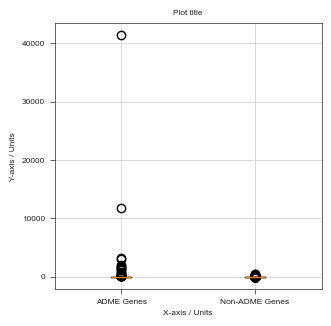

In [76]:
# In PHARMGKB
df = pd.read_csv(os.path.join(PGKBPATH, "13_pgkb_merged.csv"), low_memory=False)
admegenes = pd.read_csv(os.path.join(DATAPATH, "of_interest", "adme_gene_list.tsv"), sep="\t")
genes = admegenes["Gene Symbol"].tolist()
print(len(set(genes))) #CYP20A1 is repeated!

genesmissing = list(set(genes)-set(df["gene"]))
print(len(set(genesmissing)))

admevars = df[df["gene"].isin(genes)]
nonadmevars = df[~df["gene"].isin(genes)]

admevars_counts = admevars['gene'].value_counts().reset_index()
admevars_counts.columns = ['gene', 'frequency']
nonadmevars_counts = nonadmevars['gene'].value_counts().reset_index()
nonadmevars_counts.columns = ['gene', 'frequency']

missing_admevars_df = pd.DataFrame({'gene': list(genesmissing), 'frequency': 0})
admevars_counts = pd.concat([admevars_counts, missing_admevars_df], ignore_index=True)

fig, axs = st.create_figure(1,1)
ax = axs.next()
plt.boxplot([admevars_counts['frequency'], nonadmevars_counts['frequency']], labels=['ADME Genes', 'Non-ADME Genes'])

13


{'whiskers': [<matplotlib.lines.Line2D at 0x32a0354d0>,
 'caps': [<matplotlib.lines.Line2D at 0x32a034490>,
 'boxes': [<matplotlib.lines.Line2D at 0x32a0b1410>,
 'medians': [<matplotlib.lines.Line2D at 0x32c349290>,
 'fliers': [<matplotlib.lines.Line2D at 0x32c348410>,
 'means': []}

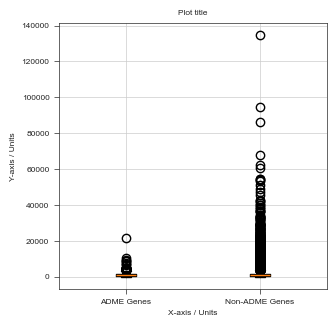

In [78]:
# in 1000 Genomes
df = pd.read_csv(os.path.join(DATAPATH, "variants", "1000_Genomes", "subset_snvs_protein_coding_1kGPhg38_gene_level.tsv"), sep="\t")
genesmissing = list(set(genes)-set(df["gene"]))
print(len(set(genesmissing)))

admevars = df[df["gene"].isin(genes)]
nonadmevars = df[~df["gene"].isin(genes)]

admevars_counts = admevars[['gene', 'total_variants']]
nonadmevars_counts = nonadmevars[['gene', 'total_variants']]

missing_admevars_df = pd.DataFrame({'gene': list(genesmissing), 'total_variants': 0})
admevars_counts = pd.concat([admevars_counts, missing_admevars_df], ignore_index=True)

fig, axs = st.create_figure(1,1)
ax = axs.next()
plt.boxplot([admevars_counts['total_variants'], nonadmevars_counts['total_variants']], labels=['ADME Genes', 'Non-ADME Genes'])

In [ ]:
# plot histogram of ADME Genes

## Figure 1C

Origin of variants in ADME Genes

In [79]:
admevars

,ensemble_id,gene,total_variants,intron_variants,missense_variants,other_variants,afr_abundant_variants,afr_abundant_intron_variants,afr_abundant_missense_variants,afr_abundant_other_variants,afr_specific_variants,afr_specific_intron_variants,afr_specific_missense_variants,afr_specific_other_variants,afr_specific_missense_variants_mutations
108,ENSG00000142583,SLC2A5,1109,840,27,0,59,38,0,0,0,0,0,0,NaN
156,ENSG00000162496,DHRS3,1524,1407,16,0,82,76,0,0,0,0,0,0,NaN
232,ENSG00000159423,ALDH4A1,1179,925,49,0,70,52,1,0,0,0,0,0,NaN
258,ENSG00000158825,CDA,788,760,11,0,69,68,0,0,0,0,0,0,NaN
634,ENSG00000142973,CYP4B1,733,527,46,0,50,33,2,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18431,ENSG00000100197,CYP2D6,51,0,0,0,8,0,0,0,0,0,0,0,NaN
18437,ENSG00000100243,CYB5R3,1473,911,19,0,81,57,1,0,1,0,1,0,p.Thr117Ser
18450,ENSG00000130540,SULT4A1,1123,1067,6,0,73,71,0,0,1,1,0,0,NaN
18513,ENSG00000100299,ARSA,229,48,34,0,17,5,2,0,0,0,0,0,NaN


In [ ]:
adme_vars = 